# Instalaciones necesarias

In [63]:
#!pip install nltk
#!pip install numpy
#!pip install matplotlib
#!python -m nltk.downloader book

# Importar librerías necesarias y obtener corpus

In [64]:
import nltk
import numpy as np
from nltk import hmm
from nltk.tag import tnt
import logging
import time
import math
from matplotlib import pyplot as plt

nltk.download('cess_esp')

from nltk.corpus import cess_esp

logging.basicConfig(
    format="%(asctime)s %(levelname)-8s %(message)s",
    level=logging.INFO,
    datefmt="%Y-%m-%d %H:%M:%S",
)

list_pairs = np.array(cess_esp.tagged_sents(), dtype=object)

logging.info(f"Shape of the corpus: {list_pairs.shape}")

[nltk_data] Downloading package cess_esp to /root/nltk_data...
[nltk_data]   Package cess_esp is already up-to-date!


2021-10-05 08:57:10 INFO     Shape of the corpus: (6030,)


# Transformar las secuencias

In [65]:
result = [None] * len(list_pairs)
for index, sentence in enumerate(list_pairs):
  sentence_result = []
  for word in sentence:
    if word[0] == u'*0*':
      continue
    value = 2
    if word[1].startswith('v') or word[1].startswith('F'):
      value = 3
    sentence_result.append((word[0], word[1][:value]))
  result[index] = sentence_result
result = np.array(result, dtype=object)

logging.info(f"Shape of the result: {result.shape}")

2021-10-05 08:57:11 INFO     Shape of the result: (6030,)


# Dividir en training y validation

In [66]:
training_ratio = 0.9

len_training = int(result.shape[0] * training_ratio)

training_list = result[:len_training]
validation_list = result[len_training:]

logging.info(f"Training length: {len_training}")
logging.info(f"Validation length: {result.shape[0] - len_training}")

2021-10-05 08:57:11 INFO     Training length: 5427
2021-10-05 08:57:11 INFO     Validation length: 603


# Entrenar HMM

In [67]:
init = time.time()
hmm_instance = hmm.HiddenMarkovModelTagger.train(training_list)
hmm_accuracy = hmm_instance.evaluate(validation_list)
logging.info(f"Trained and evaluated in {time.time() - init:4.2f}s")
logging.info(f"Accuracy {hmm_accuracy*100:=3.2f}%")

2021-10-05 08:57:23 INFO     Trained and evaluated in 11.89s
2021-10-05 08:57:23 INFO     Accuracy 87.84%


# Entrenar TNT

In [68]:
init = time.time()

tnt_instance = tnt.TnT()
tnt_instance.train(training_list)
tnt_accuracy = tnt_instance.evaluate(validation_list)

logging.info(f"Trained and evaluated in {time.time() - init:4.2f}s")
logging.info(f"Accuracy {tnt_accuracy*100:=3.2f}%")

2021-10-05 08:58:06 INFO     Trained and evaluated in 43.20s
2021-10-05 08:58:06 INFO     Accuracy 82.55%


# Funciones auxiliaresa para el cross-validation

In [69]:
def cross_validation(data, train_evaluate_function, blocks=10):
  elements_per_block = math.ceil(data.shape[0] / blocks)
  accuracies = []

  for i in range(blocks):
    test_indexes = set([i for i in range(i * elements_per_block, (i + 1) * elements_per_block)])
    training_indexes = set([i for i in range(data.shape[0])])
    training_indexes = training_indexes - test_indexes

    training_items = data[list(training_indexes)]
    test_items = data[list(test_indexes)]

    accuracies.append(train_evaluate_function(training_items, test_items))
  return accuracies

def confidence_error(p, n):
  return 1.95 * np.sqrt(p * (1 - p) / n)

def plot_accuracies(accuracies, data, blocks=10):
  elements_per_block = math.ceil(data.shape[0] / blocks)

  block_iterator = range(1, blocks + 1)
  tic = [confidence_error(accuracies[i - 1], elements_per_block) for i in block_iterator]

  plt.plot(block_iterator, accuracies, 'ro')

  plt.xlabel('Block')
  plt.ylabel('Accuracy')
  plt.title('Cross validation')

  axes = plt.gca()
  axes.set_ylim([0.8, 1.0])

  plt.errorbar(block_iterator, accuracies, yerr=tic, linestyle='None')

  plt.show()

# 10-Cross Validation con el orden original

## HMM 10-Cross validation


In [70]:
def training_evaluate_hmm(training, test):
  hmm_instance = hmm.HiddenMarkovModelTagger.train(training)
  return hmm_instance.evaluate(test)

hmm_accuracies = cross_validation(result, training_evaluate_hmm)

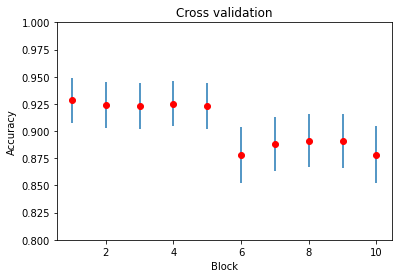

In [71]:
plot_accuracies(hmm_accuracies, result)

## TNT 10-Cross validation



In [72]:
def training_evaluate_tnt(training, test):
  tnt_instance = tnt.TnT()
  tnt_instance.train(training)

  return tnt_instance.evaluate(test)

tnt_accuracies = cross_validation(result, training_evaluate_tnt)

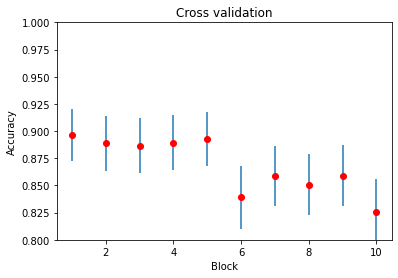

In [73]:
plot_accuracies(tnt_accuracies, result)

# 10-Cross Validation con el orden modificado


In [74]:
data_shuffled = result.copy()
np.random.shuffle(data_shuffled)

## HMM 10-Cross validation


In [75]:
def training_evaluate_hmm(training, test):
  hmm_instance = hmm.HiddenMarkovModelTagger.train(training)
  return hmm_instance.evaluate(test)

hmm_shuffled_accuracies = cross_validation(data_shuffled, training_evaluate_hmm)

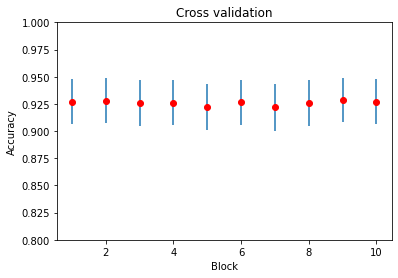

In [76]:
plot_accuracies(hmm_shuffled_accuracies, data_shuffled)

## TNT 10-Cross validation



In [77]:
def training_evaluate_tnt(training, test):
  tnt_instance = tnt.TnT()
  tnt_instance.train(training)

  return tnt_instance.evaluate(test)

tnt_shuffled_accuracies = cross_validation(data_shuffled, training_evaluate_tnt)

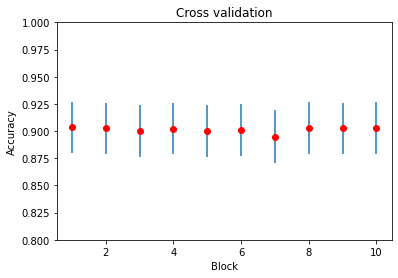

In [78]:
plot_accuracies(tnt_shuffled_accuracies, data_shuffled)